# 필요한 라이브러리 불러오기 

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [4]:
#한글깨짐 해결
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumSquare'

# 데이터 불러오기 

In [5]:
origin_df=pd.read_csv("C:\\Users\\seses\\Desktop\\하계URP_2023\\1주차_교수님께보낼내용\\[urp] 전처리 한 데이터.csv")

# 필요 없는 열 삭제 

In [8]:
origin_df.drop('BIZ_NO', axis=1, inplace=True)

In [9]:
origin_df.drop('결산년월', axis=1, inplace=True)

# 데이터 분할

In [10]:
y = origin_df['Target']
y.shape

(35767,)

In [11]:
X = origin_df.drop(labels=['Target'], axis=1)
X.shape

(35767, 54)

In [12]:
#모델 학습을 위한 데이터셋 분리
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) 

# 라벨인코딩

In [13]:
from sklearn.preprocessing import LabelEncoder 

In [14]:
nunique = X_train.nunique()
types = X_train.dtypes

categorical_columns = []
categorical_dims =  {}
for col in X_train.columns:
    if types[col] == 'object' or nunique[col] < 200:
        print(col, X_train[col].nunique())
        l_enc = LabelEncoder()
        X_train[col] = l_enc.fit_transform(X_train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)

재무결측치개수 28
HDOF_BR_GB 2
FR_IVST_CORP_YN 2
VENT_YN 2
MDSCO_PRTC_YN 2
ESTB_GB 8
Industry 19
Stock_OX 5
신생기업여부 3


In [15]:
nunique = X_test.nunique()
types = X_test.dtypes

categorical_columns = []
categorical_dims =  {}
for col in X_test.columns:
    if types[col] == 'object' or nunique[col] < 200:
        print(col, X_test[col].nunique())
        l_enc = LabelEncoder()
        X_test[col] = l_enc.fit_transform(X_test[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)

재무결측치개수 23
HDOF_BR_GB 2
FR_IVST_CORP_YN 2
VENT_YN 2
MDSCO_PRTC_YN 2
ESTB_GB 6
Industry 19
Stock_OX 4
신생기업여부 3


# 랜덤포레스트

## 하이퍼파라미터 튜닝

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# 그리드 서치
params = {
    'n_estimators': [100],
    'max_depth': [6, 8, 10, 12],
    'min_samples_leaf': [8, 12, 18],
    'min_samples_split': [8, 16, 20]
}

rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train, y_train)

print('최적의 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도:{0:.4f}'.format(grid_cv.best_score_))

최적의 하이퍼 파라미터:
 {'max_depth': 12, 'min_samples_leaf': 8, 'min_samples_split': 20, 'n_estimators': 100}
최고 예측 정확도:0.9339


## 모델링

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


rf_clf = RandomForestClassifier(max_depth=12, min_samples_leaf=8, min_samples_split=20, n_estimators=100,random_state=0)
rf_clf.fit(X_train,y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test,pred)
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy))

랜덤 포레스트 정확도: 0.9364


## 모델링 정확도 계산

### ROC curve

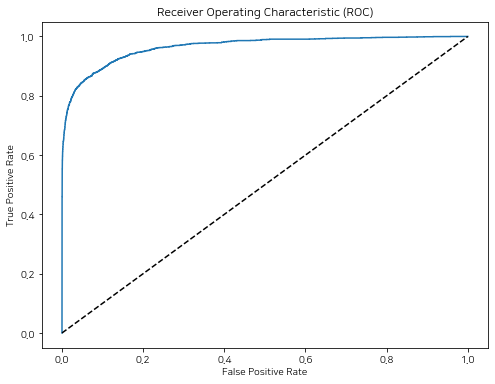

In [18]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# 예측 확률 계산
y_pred_proba = rf_clf.predict_proba(X_test)[:, 1]

# ROC 곡선 생성
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# ROC 곡선 그리기
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')  # 기준 선 (랜덤 모델)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.show()


In [19]:
from sklearn.metrics import roc_curve, roc_auc_score
auc_score = roc_auc_score(y_test, y_pred_proba)

print("AUC Score:", auc_score)

AUC Score: 0.9651433467841622


### KS Score

In [20]:
#KS Score
from scipy import interpolate
from scipy import spatial
from scipy import stats
from scipy.cluster import hierarchy

In [21]:
#Random Forest 
prediction_RF = rf_clf.predict(X_test)

print('Random Forest 모델 KS Score :')
stats.ks_2samp(pd.DataFrame(prediction_RF)[y_test.reset_index(drop=True)==0].values.flatten(), 
               pd.DataFrame(prediction_RF)[y_test.reset_index(drop=True)==1].values.flatten())

Random Forest 모델 KS Score :


KstestResult(statistic=0.69756759801038, pvalue=1.0)

### F1 Score

In [37]:
from sklearn.metrics import f1_score
pred = rf_clf.predict(X_test)

# XGBoost 모델로 예측한 결과와 실제 레이블을 가지고 있는 데이터를 사용하여 F1 스코어 계산
def calculate_f1_score(y_test, pred):
    f1 = f1_score(y_test, pred)
    return f1

# F1 스코어 계산
f1_score = calculate_f1_score(y_test,pred)
print("F1 score:", f1_score)

F1 score: 0.8119139547710976


## Feature Importance

In [22]:
# 특성 중요도 계산
importance = rf_clf.feature_importances_

# 중요도를 기준으로 특성 인덱스 정렬
indices = np.argsort(importance)[::-1]

# 특성 중요도 출력
for i, feature in enumerate(X.columns[indices]):
    print(f"{i + 1}. {feature}: {importance[indices[i]]}")

1. 자산총계: 0.1643613158196689
2. 부채총계: 0.1206884532705958
3. 유동부채: 0.09031661118647559
4. 유동자산: 0.0649145400491216
5. 자본총계: 0.046064438229711555
6. 판매비와관리비: 0.043318954069908155
7. 매출액: 0.03750855324351748
8. 비유동자산: 0.03583843969175616
9. HDOF_BR_GB: 0.026245918117167116
10. 유형자산: 0.025868824081246238
11. 경상수지비율(%): 0.02430843542921881
12. EMP_CNT: 0.02323245530696242
13. 비유동부채: 0.022700507571730737
14. 부채총계대 매출액(%): 0.020567076784566644
15. 매출원가: 0.016942730529106283
16. 이익잉여금(결손금）: 0.01577534374035778
17. Industry: 0.01370688955729821
18. 유보액/총자산(%): 0.011005456978574161
19. 매입채무회전율(%): 0.010809796236708481
20. 순운전자본비율(%): 0.009969654410597542
21. 자본금: 0.009475688529376207
22. 당기순이익(손실): 0.009312738783546232
23. 유보액/납입자본(%): 0.009135513717509777
24. 부채비율(%): 0.008986662333879675
25. 총자본회전율(%): 0.008741816418183621
26. 법인세비용차감전순손익: 0.008481804071744786
27. 매출액영업이익률(%): 0.0081052783217289
28. 신생기업여부: 0.007439978698585968
29. 매출액순이익률(%): 0.00704637014369011
30. 매출채권회전율(%): 0.0067988911364

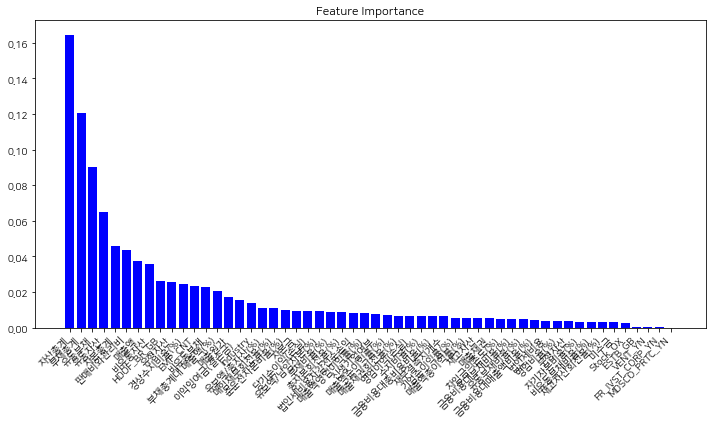

In [23]:
# 중요도를 기준으로 특성 인덱스 정렬
indices = np.argsort(importance)[::-1]

# 특성 이름 배열
features = X.columns

# 그래프 생성
plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(range(len(indices)), importance[indices], color='b', align='center')

# x축에 특성 이름 표시
plt.xticks(range(len(indices)), features[indices], rotation=45, ha='right')  # x축 그래프명을 45도로 회전하여 표시

# 그래프 출력
plt.tight_layout()
plt.show()


## shap_value

In [20]:
import shap

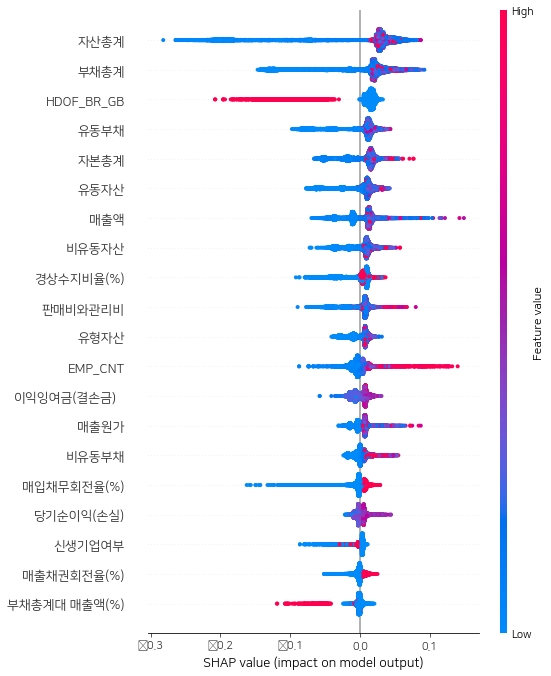

In [31]:
explainer = shap.TreeExplainer(rf_clf)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[0], X_test) #생존

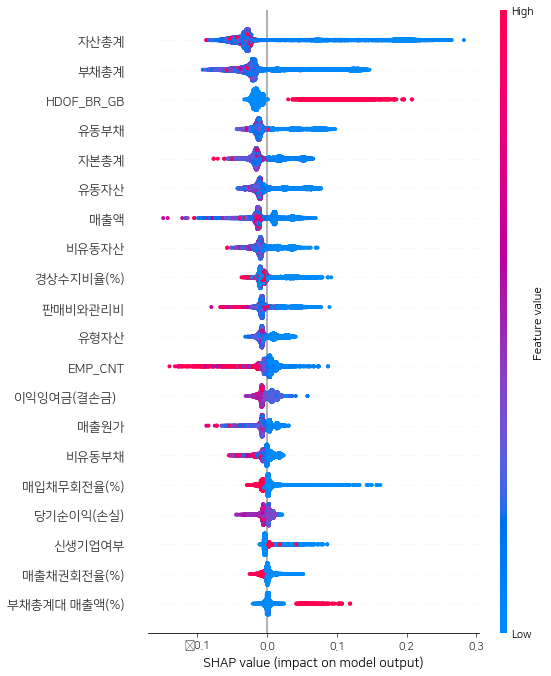

In [32]:
shap.summary_plot(shap_values[1], X_test) #휴폐업

# XGBoost

## 하이퍼파라미터 튜닝

- 런타임 오류 발생

In [ ]:
""""
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# XGBoost 모델 생성
model = xgb.XGBClassifier()

# 튜닝할 파라미터 그리드 설정
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 500, 1000],
    'colsample_bytree': [0.5, 0.7, 0.9],
    'subsample': [0.5, 0.7, 0.9]
}

# 그리드 서치 수행
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)

# 최적의 파라미터와 스코어 출력
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)
""""

## 모델링

In [24]:
from xgboost import XGBClassifier

# 모델 선언 예시
xgb = XGBClassifier(n_estimators=500, learning_rate=0.2, max_depth=4, random_state = 32)

In [25]:
xgb.fit(X_train,y_train)
pred = xgb.predict(X_test)
accuracy = accuracy_score(y_test,pred)
print('XGBoost 정확도: {0:.4f}'.format(accuracy))

XGBoost 정확도: 0.9487


## 모델링 정확도 계산

### ROC curve

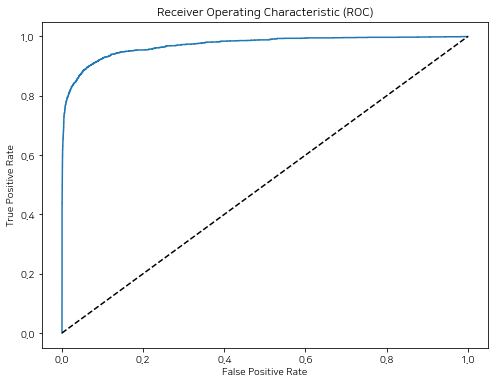

In [27]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# 예측 확률 계산
y_pred_proba = xgb.predict_proba(X_test)[:, 1]

# ROC 곡선 생성
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# ROC 곡선 그리기
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')  # 기준 선 (랜덤 모델)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.show()

### KS Score

In [31]:
#KS Score
from scipy import interpolate
from scipy import spatial
from scipy import stats
from scipy.cluster import hierarchy

In [32]:
#Random Forest 
prediction_RF = xgb.predict(X_test)

print('Random Forest 모델 KS Score :')
stats.ks_2samp(pd.DataFrame(prediction_RF)[y_test.reset_index(drop=True)==0].values.flatten(), 
               pd.DataFrame(prediction_RF)[y_test.reset_index(drop=True)==1].values.flatten())

Random Forest 모델 KS Score :


KstestResult(statistic=0.7869860845005341, pvalue=1.0)

### F1 Score

In [30]:
from sklearn.metrics import f1_score

# XGBoost 모델로 예측한 결과와 실제 레이블을 가지고 있는 데이터를 사용하여 F1 스코어 계산
def calculate_f1_score(y_test, pred):
    f1 = f1_score(y_test, pred)
    return f1

# F1 스코어 계산
pred = xgb.predict(X_test)
f1_score = calculate_f1_score(y_test, pred)
print("F1 score:", f1_score)

F1 score: 0.8590466427473091


## Feature Importance

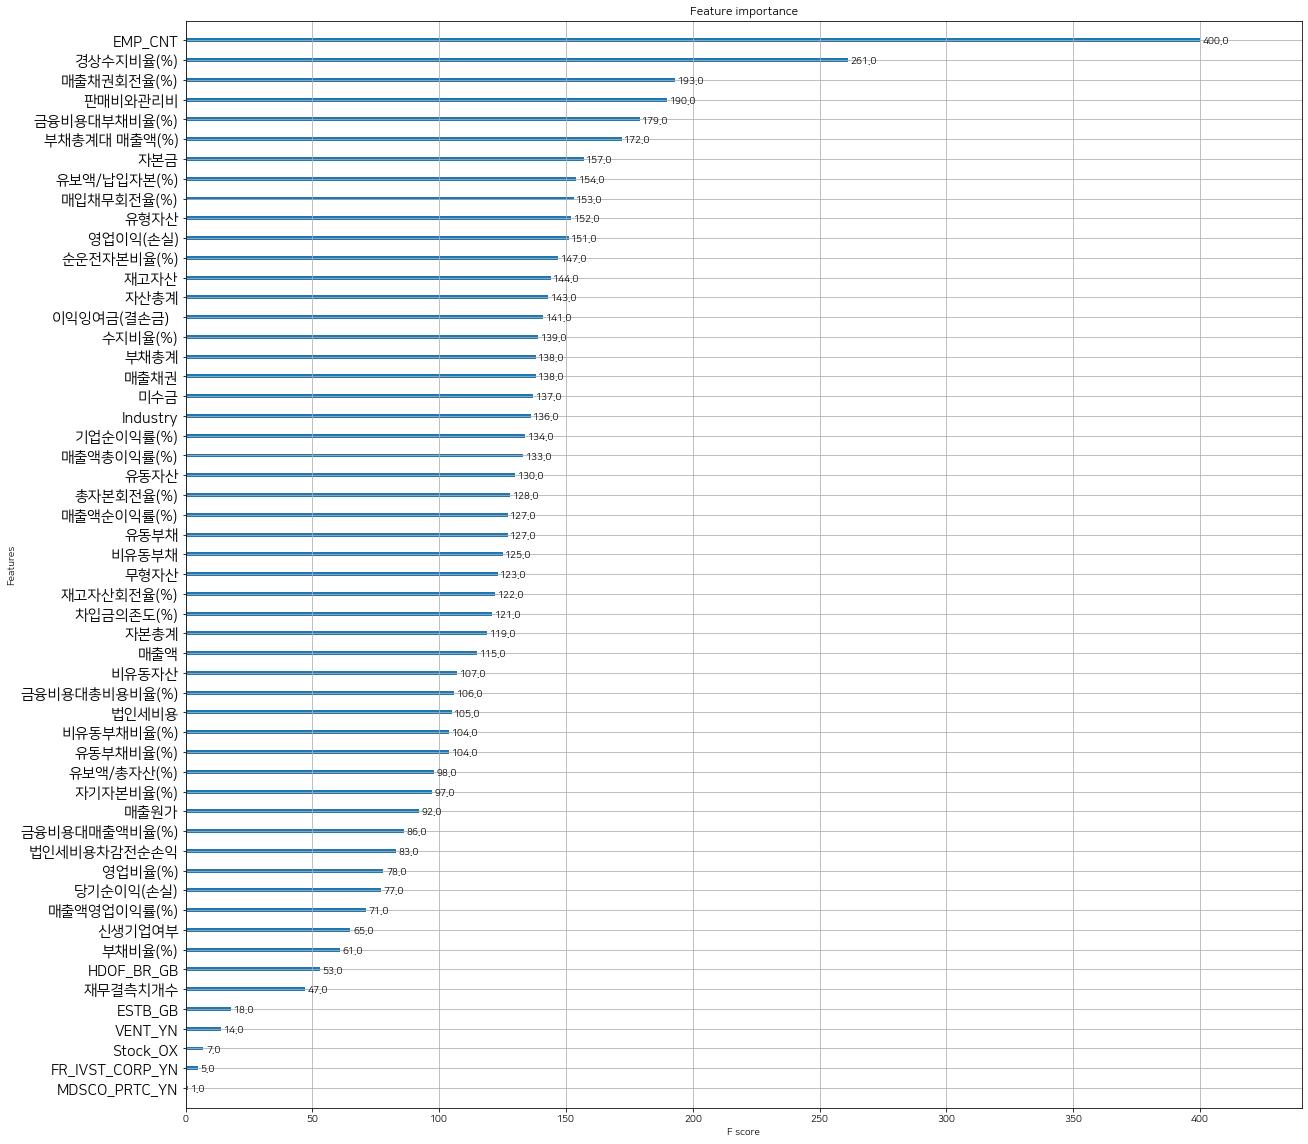

In [34]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20, 20)  # rcParams를 plt.rcParams로 수정

plot_importance(xgb)
plt.yticks(fontsize=15)
plt.show()